Affective workflow!!

In [1]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from Affective_Computing.getPipeData import get_pipe_data
import cv2
from pygame import Rect, Vector2
import numpy as np
import matplotlib.pyplot as plt
from Affective_Computing.PointCloud import FaceCloud
import TrainedInceptionResnetV2
from joblib import dump, load

pygame 2.5.2 (SDL 2.28.3, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
im_path = "Affective_Computing/Sample_Images/Happy_26.png"
# im_path = "Affective_Computing/Sample_Images/Ben Glasses.png"

# get image as RGB array
img_array = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2RGB)
# get image as mediapipe image
img_mp = mp.Image(data=img_array, image_format=mp.ImageFormat.SRGB)

Initialise mediapipe face detector and process loaded image

In [3]:
base_options = python.BaseOptions(model_asset_path='Affective_Computing/face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options, output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True, num_faces=1, )
detector = vision.FaceLandmarker.create_from_options(options)
face_landmarks, blend_data, _ = get_pipe_data(detector, img_mp)

W0000 00:00:1699873650.677709       1 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## Image Segmentation
crop face region from image

In [4]:
def segment_face(landmarks, img_array):
    px_locations_x = landmarks[:, 0] * img_array.shape[1]
    px_locations_y = landmarks[:, 1] * img_array.shape[0]
    
    max_x, min_x = max(px_locations_x), min(px_locations_x)
    max_y, min_y = max(px_locations_y), min(px_locations_y)
    
    # create bounding box of face and scale to adjust for full head region
    scale = Vector2(1.8, 1.6)
    bbox = np.asarray([min_x, min_y, max_x-min_x, max_y-min_y], dtype=np.int16)
    face_rect = Rect(bbox).scale_by(scale.x, scale.y)
    face_rect = face_rect.clip(Rect((0, 0), img_array.shape[:2]))
    cropped_img = img_array[face_rect.top:face_rect.bottom, face_rect.left:face_rect.right]
    
    return cropped_img

Segment and resize image for input to InceptionResNetV2

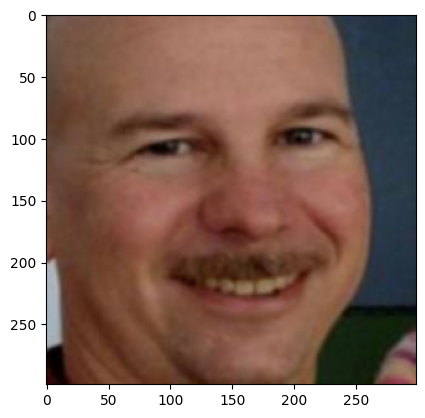

In [5]:
img_face = segment_face(face_landmarks, img_array)
img_face = cv2.resize(img_face, (299, 299))
plt.imshow(img_face)
plt.show()

In [6]:
model = TrainedInceptionResnetV2.load_model()
net_data = model.predict(np.expand_dims(img_face, axis=0))
class_names = ["Anger", "Contempt", "Disgust", "Happy", "Neutral", "Fear", "Sad", "Surprise"]
class_names[np.argmax(net_data)]

1/1 [==============================] - 2s 2s/step


'Neutral'

Create the shape feature from 3D landmark locations

In [7]:
face = FaceCloud(face_landmarks)
face.preprocess()

In [8]:
import pickle
with open("Affective_Computing/Reference.pickle", "rb") as file:
    ref_face = pickle.load(file)
    
shape_feature = face.create_shape_feature(demo=True)

ModuleNotFoundError: No module named 'PointCloud'

In [ ]:
delta_feature = face.create_delta_feature(ref_face, demo=True)

Bring together all predictors

In [ ]:
# fusion_feature = np.concatenate([net_data.flatten(), shape_feature, blend_data])
fusion_feature = np.concatenate([shape_feature, blend_data, net_data.flatten()])
print(fusion_feature.shape)

In [ ]:
svm = load("Affective_Computing/AffectSVM.joblib")

In [ ]:
prediction = svm.predict(np.expand_dims(fusion_feature, axis=0))
class_names[int(prediction[0])]